In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [5]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [6]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(15,16):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.15
(1200, 36, 256, 1)
(1200,) (600,) (600,)
(1200,) (570,) (630,)


0

In [7]:
def simple_2D_CNN(x): 
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 32, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 64, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 64, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 64, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2], 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 36, 256, 32)  544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 36, 256, 32)  352         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 36, 256, 32)  224         ['input_1[0][0]']            

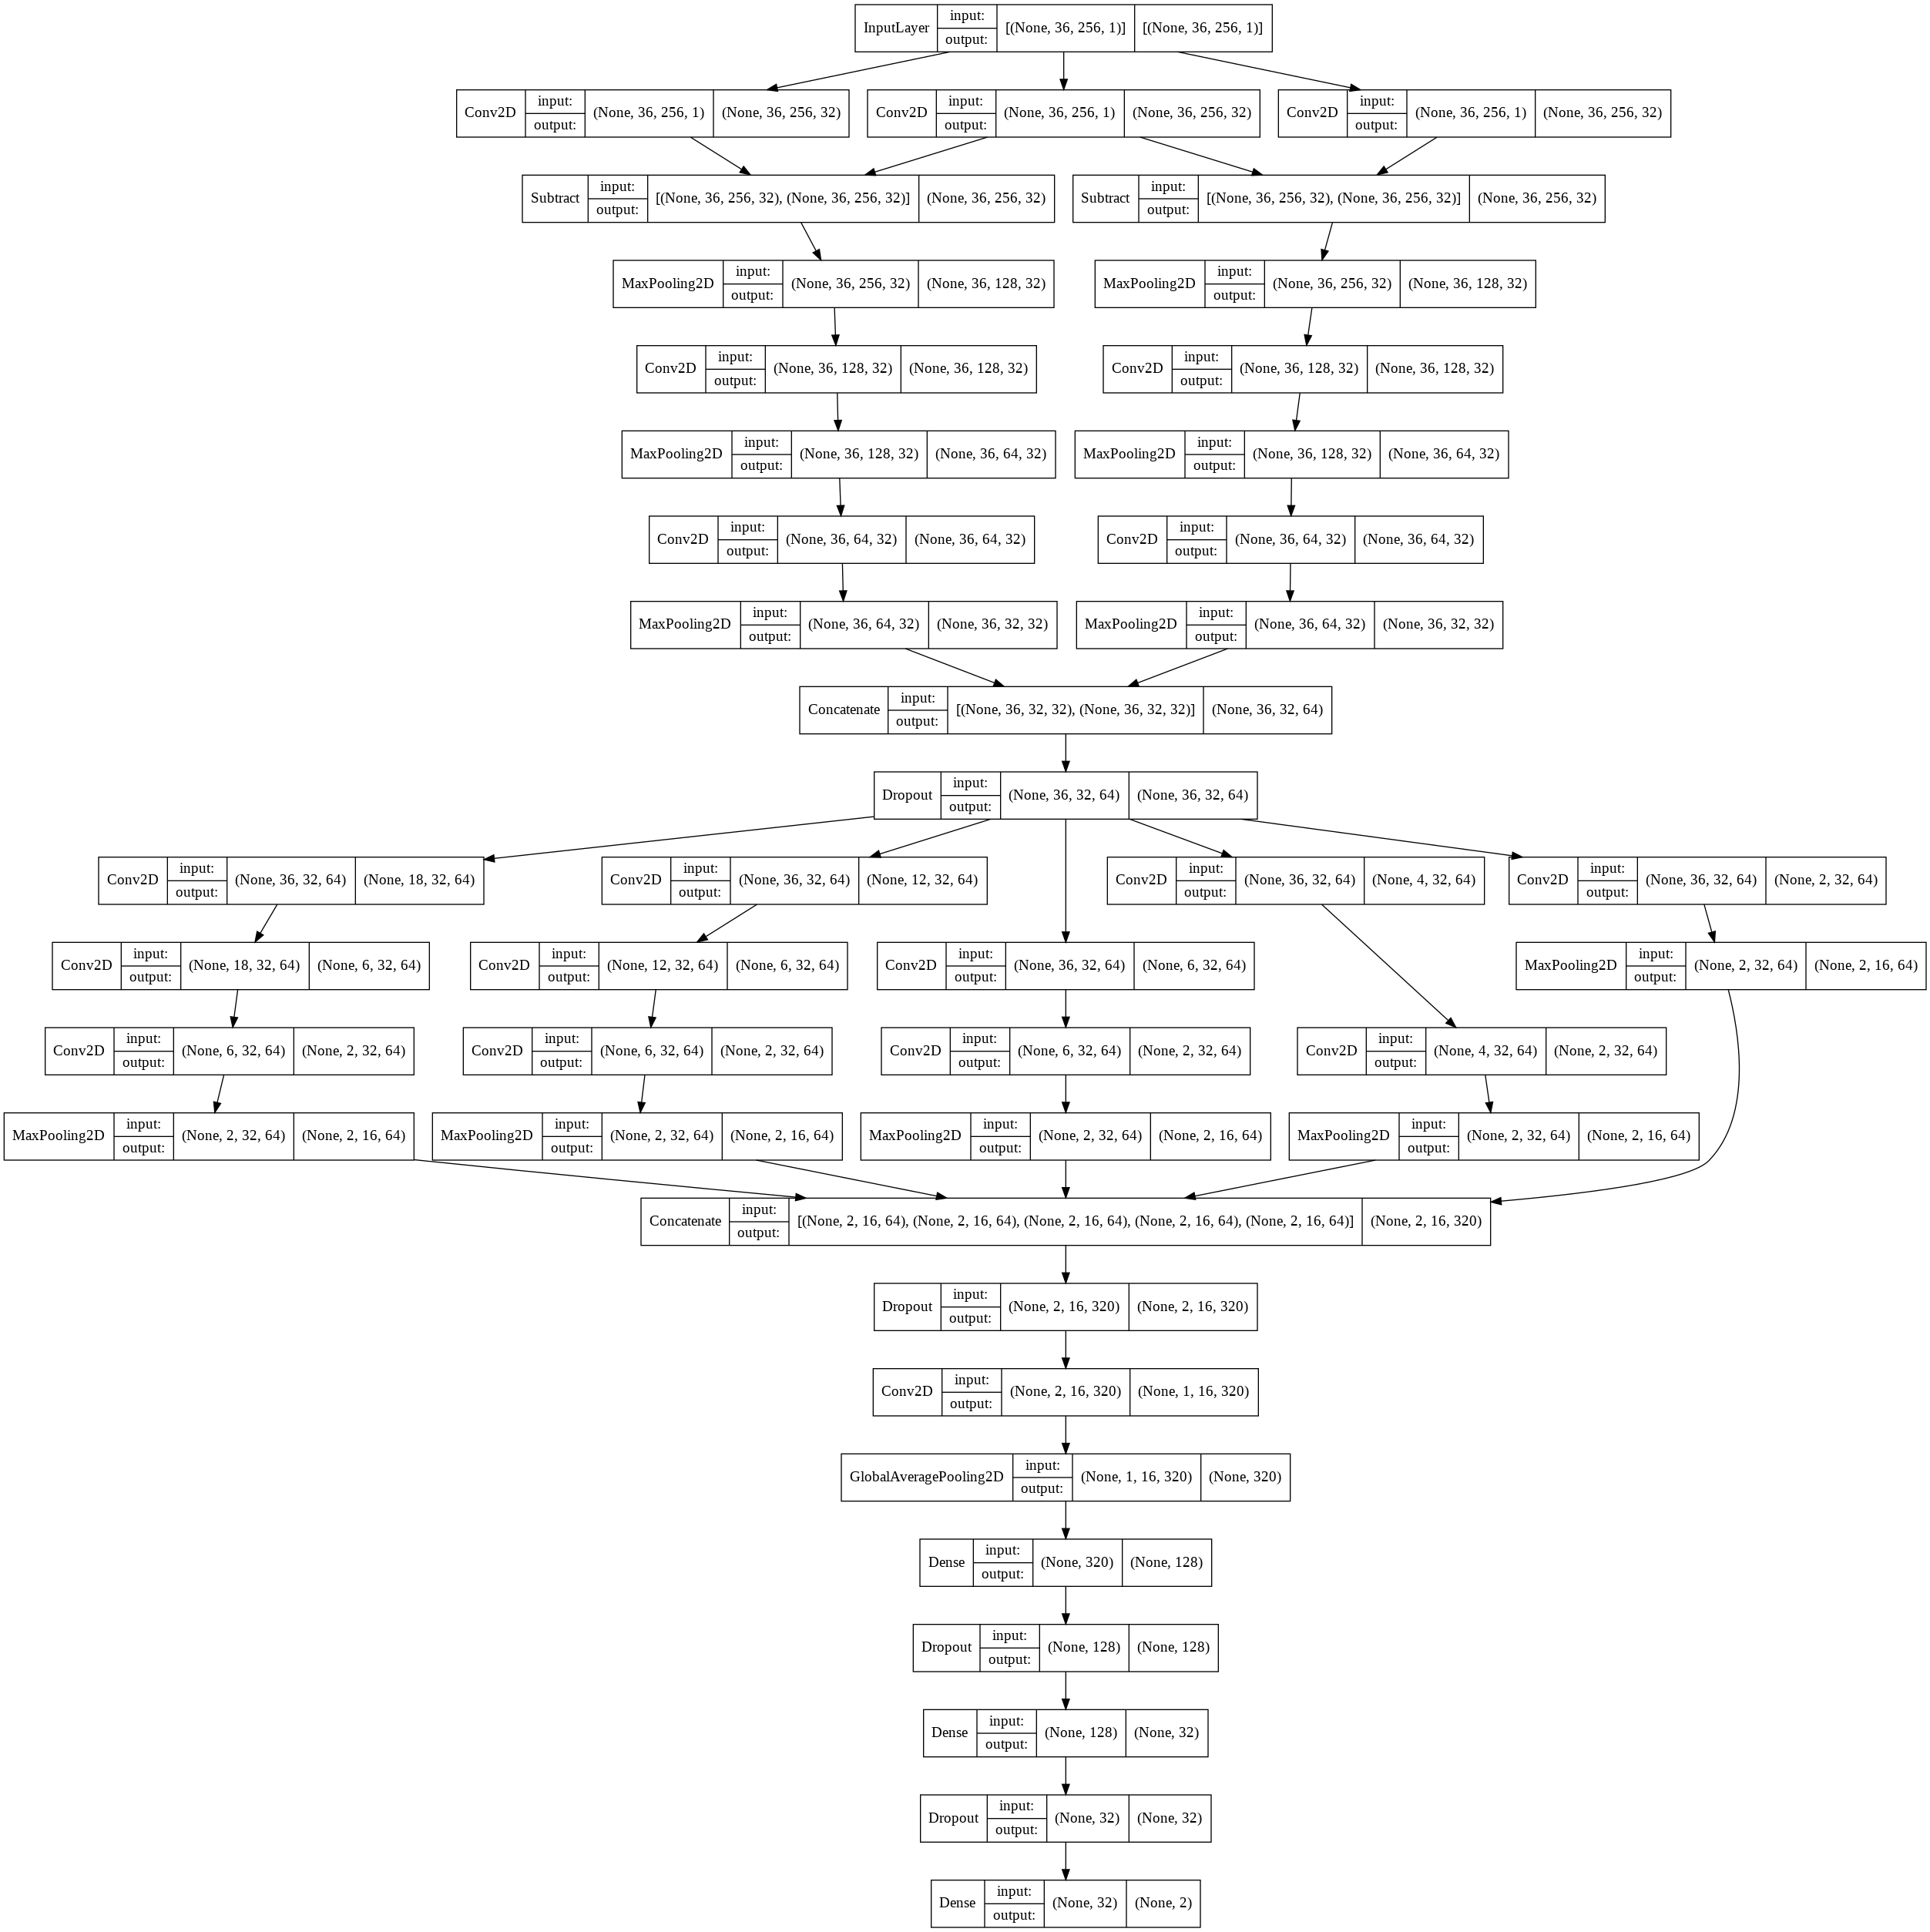

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [9]:
batch_size = 64
epochs = 50
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

0

In [10]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [11]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/50
16/16 [==============================] - 16s 185ms/step - loss: 0.7029 - accuracy: 0.5412 - val_loss: 0.6727 - val_accuracy: 0.5833
Epoch 2/50
16/16 [==============================] - 2s 101ms/step - loss: 0.6446 - accuracy: 0.6348 - val_loss: 0.5981 - val_accuracy: 0.6389
Epoch 3/50
16/16 [==============================] - 2s 102ms/step - loss: 0.6010 - accuracy: 0.6780 - val_loss: 0.5525 - val_accuracy: 0.7315
Epoch 4/50
16/16 [==============================] - 2s 101ms/step - loss: 0.5233 - accuracy: 0.7459 - val_loss: 0.4702 - val_accuracy: 0.8056
Epoch 5/50
16/16 [==============================] - 2s 101ms/step - loss: 0.4903 - accuracy: 0.7675 - val_loss: 0.5297 - val_accuracy: 0.7130
Epoch 6/50
16/16 [==============================] - 2s 101ms/step - loss: 0.4429 - accuracy: 0.8056 - val_loss: 0.3851 - val_accuracy: 0.8333
Epoch 7/50
16/16 [==============================] - 2s 101ms/step - loss: 0.3398 - accuracy: 0.8745 - val_loss: 0.2974 - val_acc

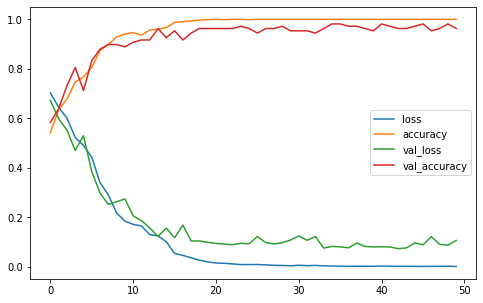

Results for fold 2
Epoch 1/50
16/16 [==============================] - 3s 123ms/step - loss: 0.7637 - accuracy: 0.5051 - val_loss: 0.6649 - val_accuracy: 0.6667
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6787 - accuracy: 0.5638 - val_loss: 0.6951 - val_accuracy: 0.4815
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6711 - accuracy: 0.5947 - val_loss: 0.6070 - val_accuracy: 0.7130
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5831 - accuracy: 0.7088 - val_loss: 0.5576 - val_accuracy: 0.7500
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5370 - accuracy: 0.7335 - val_loss: 0.4626 - val_accuracy: 0.8241
Epoch 6/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4582 - accuracy: 0.8107 - val_loss: 0.3919 - val_accuracy: 0.8519
Epoch 7/50
16/16 [==============================] - 2s 104ms/step - loss: 0.3980 - accuracy: 0.8426 - val_loss: 0.3449 - val_accu

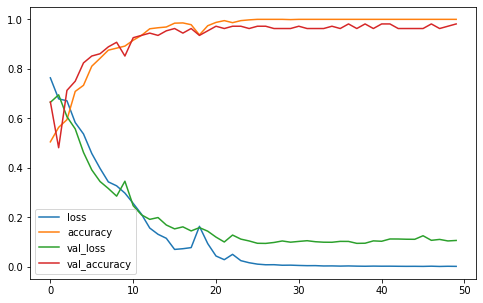

Results for fold 3
Epoch 1/50
16/16 [==============================] - 3s 121ms/step - loss: 0.7559 - accuracy: 0.5463 - val_loss: 0.6821 - val_accuracy: 0.6111
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6149 - accuracy: 0.6718 - val_loss: 0.5677 - val_accuracy: 0.7222
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5853 - accuracy: 0.6914 - val_loss: 0.4737 - val_accuracy: 0.7870
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5095 - accuracy: 0.7551 - val_loss: 0.4522 - val_accuracy: 0.8056
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4608 - accuracy: 0.8035 - val_loss: 0.3280 - val_accuracy: 0.8889
Epoch 6/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4321 - accuracy: 0.8128 - val_loss: 0.3578 - val_accuracy: 0.8796
Epoch 7/50
16/16 [==============================] - 2s 104ms/step - loss: 0.3571 - accuracy: 0.8642 - val_loss: 0.2805 - val_accu

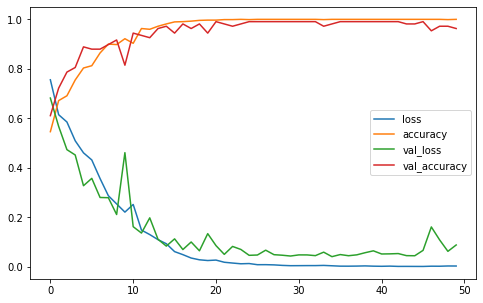

Results for fold 4
Epoch 1/50
16/16 [==============================] - 3s 125ms/step - loss: 0.7264 - accuracy: 0.5607 - val_loss: 0.6901 - val_accuracy: 0.5741
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6879 - accuracy: 0.5730 - val_loss: 0.6961 - val_accuracy: 0.5093
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6365 - accuracy: 0.6502 - val_loss: 0.5921 - val_accuracy: 0.6759
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5227 - accuracy: 0.7634 - val_loss: 0.7864 - val_accuracy: 0.5093
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5322 - accuracy: 0.7428 - val_loss: 0.4088 - val_accuracy: 0.8241
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.4223 - accuracy: 0.8220 - val_loss: 0.3524 - val_accuracy: 0.8426
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.3434 - accuracy: 0.8611 - val_loss: 0.3300 - val_accu

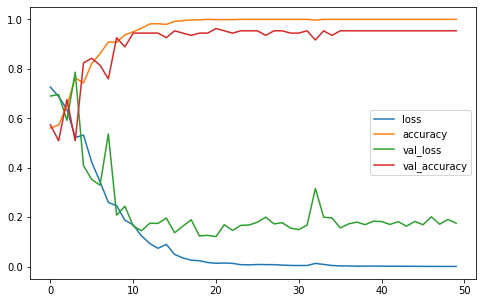

Results for fold 5
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.7353 - accuracy: 0.5329 - val_loss: 0.6675 - val_accuracy: 0.5093
Epoch 2/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6388 - accuracy: 0.6317 - val_loss: 0.5736 - val_accuracy: 0.7407
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.5523 - accuracy: 0.7181 - val_loss: 0.5973 - val_accuracy: 0.6667
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5322 - accuracy: 0.7366 - val_loss: 0.4527 - val_accuracy: 0.8519
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4553 - accuracy: 0.8056 - val_loss: 0.3653 - val_accuracy: 0.8611
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4190 - accuracy: 0.8333 - val_loss: 0.2898 - val_accuracy: 0.8889
Epoch 7/50
16/16 [==============================] - 2s 105ms/step - loss: 0.3956 - accuracy: 0.8385 - val_loss: 0.2743 - val_accu

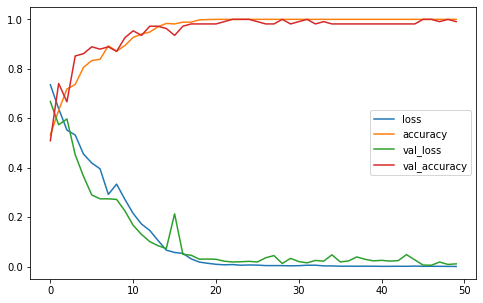

Results for fold 6
Epoch 1/50
16/16 [==============================] - 3s 124ms/step - loss: 0.7438 - accuracy: 0.5453 - val_loss: 0.6222 - val_accuracy: 0.7130
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6549 - accuracy: 0.6101 - val_loss: 0.5451 - val_accuracy: 0.7315
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6226 - accuracy: 0.6492 - val_loss: 0.5212 - val_accuracy: 0.7778
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.5701 - accuracy: 0.7191 - val_loss: 0.4539 - val_accuracy: 0.8241
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4876 - accuracy: 0.7891 - val_loss: 0.3428 - val_accuracy: 0.9074
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4211 - accuracy: 0.8364 - val_loss: 0.2994 - val_accuracy: 0.8981
Epoch 7/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4235 - accuracy: 0.8148 - val_loss: 0.2723 - val_accu

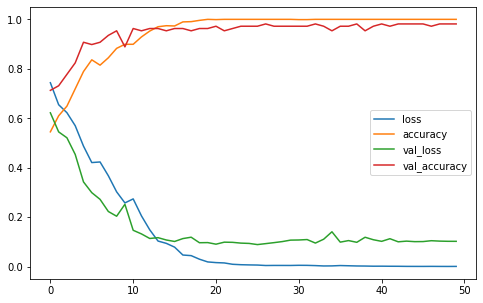

Results for fold 7
Epoch 1/50
16/16 [==============================] - 3s 124ms/step - loss: 0.8948 - accuracy: 0.5319 - val_loss: 0.6899 - val_accuracy: 0.4722
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6937 - accuracy: 0.5586 - val_loss: 0.6511 - val_accuracy: 0.6574
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.7018 - accuracy: 0.5340 - val_loss: 0.6750 - val_accuracy: 0.5556
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6734 - accuracy: 0.5761 - val_loss: 0.6574 - val_accuracy: 0.5556
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6133 - accuracy: 0.6718 - val_loss: 0.5584 - val_accuracy: 0.7222
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.5932 - accuracy: 0.6698 - val_loss: 0.5102 - val_accuracy: 0.7407
Epoch 7/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4851 - accuracy: 0.7870 - val_loss: 0.3967 - val_accu

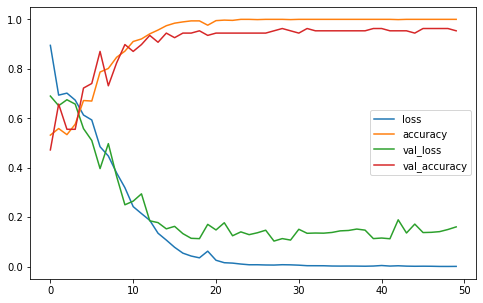

Results for fold 8
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.7231 - accuracy: 0.5226 - val_loss: 0.6341 - val_accuracy: 0.6204
Epoch 2/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6344 - accuracy: 0.6605 - val_loss: 0.5599 - val_accuracy: 0.7778
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5891 - accuracy: 0.6872 - val_loss: 0.5643 - val_accuracy: 0.7593
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5145 - accuracy: 0.7695 - val_loss: 0.4970 - val_accuracy: 0.7685
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.4759 - accuracy: 0.7922 - val_loss: 0.4126 - val_accuracy: 0.8519
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.3980 - accuracy: 0.8508 - val_loss: 0.4686 - val_accuracy: 0.7685
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.3626 - accuracy: 0.8693 - val_loss: 0.3518 - val_accu

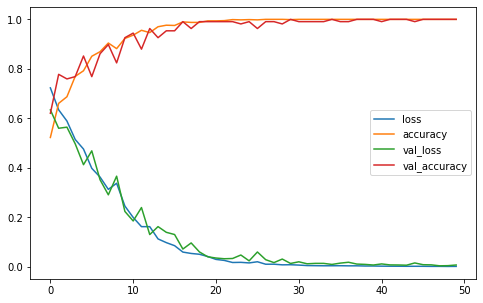

Results for fold 9
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.7583 - accuracy: 0.5309 - val_loss: 0.6284 - val_accuracy: 0.7222
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6487 - accuracy: 0.6276 - val_loss: 0.6183 - val_accuracy: 0.6481
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6336 - accuracy: 0.6440 - val_loss: 0.5741 - val_accuracy: 0.7222
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5651 - accuracy: 0.7160 - val_loss: 0.4643 - val_accuracy: 0.7778
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.4651 - accuracy: 0.7973 - val_loss: 0.4133 - val_accuracy: 0.8056
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4243 - accuracy: 0.8097 - val_loss: 0.5407 - val_accuracy: 0.7222
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.4399 - accuracy: 0.7942 - val_loss: 0.3467 - val_accu

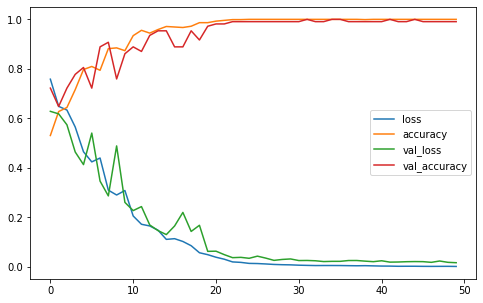

Results for fold 10
Epoch 1/50
16/16 [==============================] - 3s 124ms/step - loss: 0.7842 - accuracy: 0.5340 - val_loss: 0.6532 - val_accuracy: 0.5926
Epoch 2/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6828 - accuracy: 0.5545 - val_loss: 0.6100 - val_accuracy: 0.7222
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6578 - accuracy: 0.6111 - val_loss: 0.5561 - val_accuracy: 0.8148
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6144 - accuracy: 0.6379 - val_loss: 0.5007 - val_accuracy: 0.8056
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.5487 - accuracy: 0.7387 - val_loss: 0.6633 - val_accuracy: 0.6019
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5569 - accuracy: 0.7212 - val_loss: 0.4006 - val_accuracy: 0.8426
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.4604 - accuracy: 0.8014 - val_loss: 0.4385 - val_acc

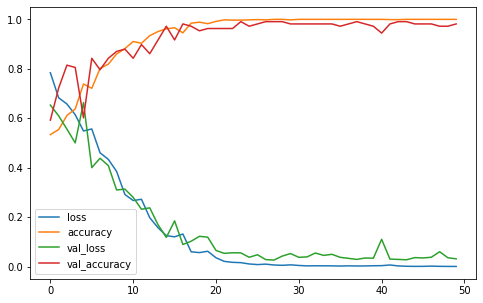

In [12]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9616666674613953
F1_Score  : 0.9615840271855017


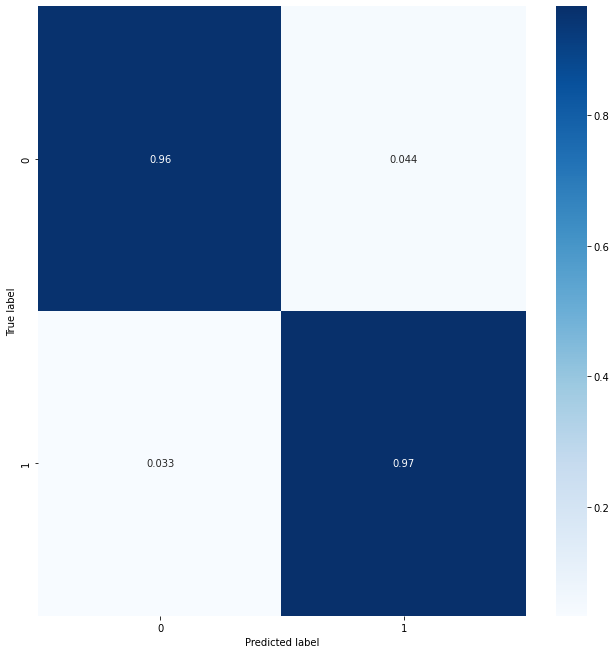

In [13]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [14]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.7622 - accuracy: 0.5185 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6844 - accuracy: 0.5556 - val_loss: 0.6717 - val_accuracy: 0.5463
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6572 - accuracy: 0.6276 - val_loss: 0.6150 - val_accuracy: 0.6574
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6102 - accuracy: 0.6636 - val_loss: 0.5854 - val_accuracy: 0.6944
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5878 - accuracy: 0.6862 - val_loss: 0.6026 - val_accuracy: 0.6852
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5453 - accuracy: 0.7315 - val_loss: 0.5271 - val_accuracy: 0.7593
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.4643 - accuracy: 0.8025 - val_loss: 0.5739 - val_accu

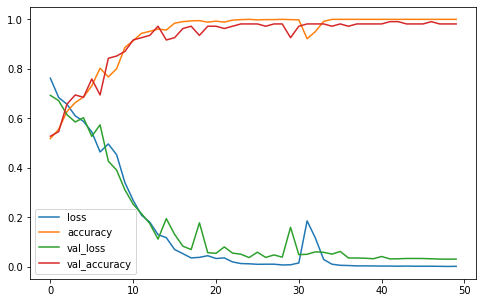

Results for fold 2
Epoch 1/50
16/16 [==============================] - 3s 123ms/step - loss: 0.7317 - accuracy: 0.5257 - val_loss: 0.6763 - val_accuracy: 0.5833
Epoch 2/50
16/16 [==============================] - 2s 103ms/step - loss: 0.6697 - accuracy: 0.5936 - val_loss: 0.7000 - val_accuracy: 0.5093
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6491 - accuracy: 0.6224 - val_loss: 0.5941 - val_accuracy: 0.6852
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5708 - accuracy: 0.7047 - val_loss: 0.5940 - val_accuracy: 0.6574
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5559 - accuracy: 0.7171 - val_loss: 0.5249 - val_accuracy: 0.7222
Epoch 6/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4772 - accuracy: 0.7850 - val_loss: 0.3921 - val_accuracy: 0.8519
Epoch 7/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4901 - accuracy: 0.7809 - val_loss: 0.4251 - val_accu

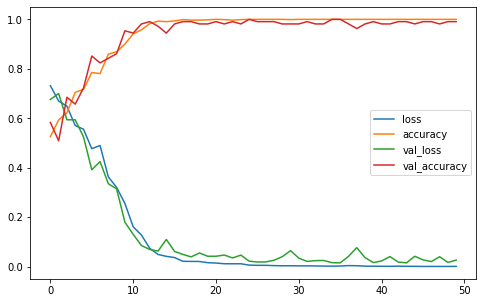

Results for fold 3
Epoch 1/50
16/16 [==============================] - 3s 123ms/step - loss: 0.7378 - accuracy: 0.5278 - val_loss: 0.6563 - val_accuracy: 0.6019
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6624 - accuracy: 0.6173 - val_loss: 0.6062 - val_accuracy: 0.7222
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6042 - accuracy: 0.6811 - val_loss: 0.5403 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5544 - accuracy: 0.7366 - val_loss: 0.4908 - val_accuracy: 0.7963
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4878 - accuracy: 0.7757 - val_loss: 0.4446 - val_accuracy: 0.7870
Epoch 6/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4163 - accuracy: 0.8189 - val_loss: 0.3282 - val_accuracy: 0.8519
Epoch 7/50
16/16 [==============================] - 2s 104ms/step - loss: 0.3228 - accuracy: 0.8745 - val_loss: 0.2544 - val_accu

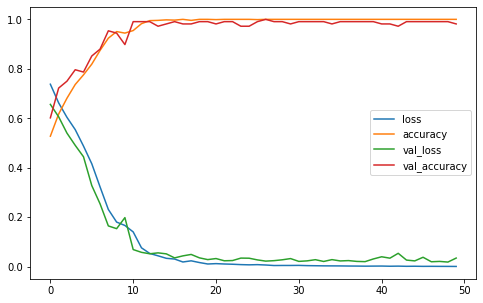

Results for fold 4
Epoch 1/50
16/16 [==============================] - 3s 123ms/step - loss: 0.7225 - accuracy: 0.5381 - val_loss: 0.6611 - val_accuracy: 0.5556
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6564 - accuracy: 0.6060 - val_loss: 0.6334 - val_accuracy: 0.6296
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.6014 - accuracy: 0.6749 - val_loss: 0.6173 - val_accuracy: 0.6574
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5878 - accuracy: 0.6739 - val_loss: 0.5176 - val_accuracy: 0.7778
Epoch 5/50
16/16 [==============================] - 2s 104ms/step - loss: 0.4963 - accuracy: 0.7654 - val_loss: 0.4164 - val_accuracy: 0.8426
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.4265 - accuracy: 0.8200 - val_loss: 0.3659 - val_accuracy: 0.8611
Epoch 7/50
16/16 [==============================] - 2s 104ms/step - loss: 0.3616 - accuracy: 0.8508 - val_loss: 0.2688 - val_accu

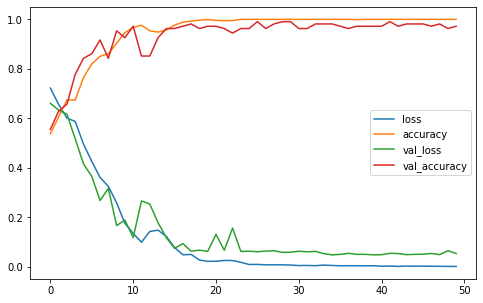

Results for fold 5
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.8069 - accuracy: 0.5391 - val_loss: 0.6383 - val_accuracy: 0.6759
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6859 - accuracy: 0.5700 - val_loss: 0.6408 - val_accuracy: 0.6481
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6673 - accuracy: 0.6132 - val_loss: 0.5521 - val_accuracy: 0.7593
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6558 - accuracy: 0.6183 - val_loss: 0.6044 - val_accuracy: 0.6019
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6039 - accuracy: 0.6646 - val_loss: 0.4816 - val_accuracy: 0.8426
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.5144 - accuracy: 0.7407 - val_loss: 0.5485 - val_accuracy: 0.7222
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.4117 - accuracy: 0.8189 - val_loss: 0.3671 - val_accu

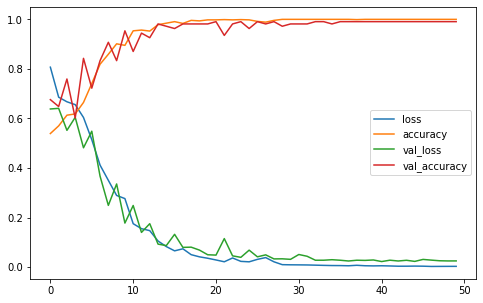

Results for fold 6
Epoch 1/50
16/16 [==============================] - 3s 128ms/step - loss: 0.7457 - accuracy: 0.5123 - val_loss: 0.6413 - val_accuracy: 0.7500
Epoch 2/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6680 - accuracy: 0.5988 - val_loss: 0.6199 - val_accuracy: 0.6481
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6376 - accuracy: 0.6276 - val_loss: 0.5606 - val_accuracy: 0.8519
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6091 - accuracy: 0.6790 - val_loss: 0.4695 - val_accuracy: 0.7685
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.5461 - accuracy: 0.7202 - val_loss: 0.4290 - val_accuracy: 0.8333
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.4643 - accuracy: 0.7870 - val_loss: 0.3197 - val_accuracy: 0.8519
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.3655 - accuracy: 0.8477 - val_loss: 0.3665 - val_accu

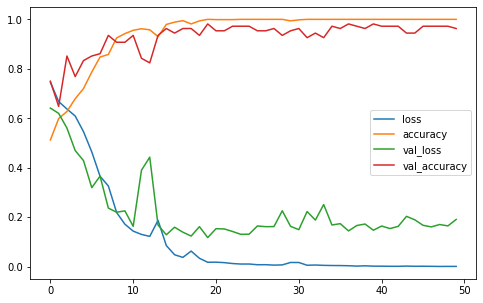

Results for fold 7
Epoch 1/50
16/16 [==============================] - 3s 122ms/step - loss: 0.7920 - accuracy: 0.4918 - val_loss: 0.6874 - val_accuracy: 0.5278
Epoch 2/50
16/16 [==============================] - 2s 105ms/step - loss: 0.7032 - accuracy: 0.5267 - val_loss: 0.6624 - val_accuracy: 0.6019
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7077 - accuracy: 0.5391 - val_loss: 0.6382 - val_accuracy: 0.6852
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6947 - accuracy: 0.5535 - val_loss: 0.6316 - val_accuracy: 0.6296
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6651 - accuracy: 0.5854 - val_loss: 0.6566 - val_accuracy: 0.4907
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6565 - accuracy: 0.5977 - val_loss: 0.6707 - val_accuracy: 0.5741
Epoch 7/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6838 - accuracy: 0.5658 - val_loss: 0.6304 - val_accu

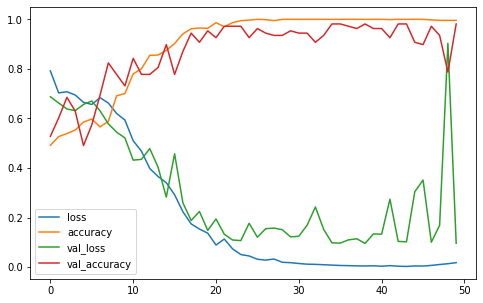

Results for fold 8
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.7833 - accuracy: 0.4784 - val_loss: 0.7185 - val_accuracy: 0.3981
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6920 - accuracy: 0.5267 - val_loss: 0.6978 - val_accuracy: 0.4167
Epoch 3/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6899 - accuracy: 0.5360 - val_loss: 0.6627 - val_accuracy: 0.6667
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6742 - accuracy: 0.5710 - val_loss: 0.6579 - val_accuracy: 0.7130
Epoch 5/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6684 - accuracy: 0.5885 - val_loss: 0.7114 - val_accuracy: 0.4722
Epoch 6/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6358 - accuracy: 0.6337 - val_loss: 0.5627 - val_accuracy: 0.7685
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6162 - accuracy: 0.6728 - val_loss: 0.5278 - val_accu

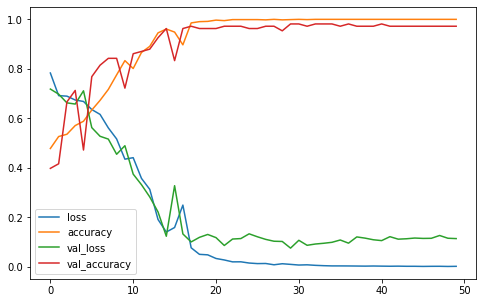

Results for fold 9
Epoch 1/50
16/16 [==============================] - 3s 125ms/step - loss: 0.8314 - accuracy: 0.5082 - val_loss: 0.6983 - val_accuracy: 0.4259
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7005 - accuracy: 0.5473 - val_loss: 0.6696 - val_accuracy: 0.7130
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6723 - accuracy: 0.5782 - val_loss: 0.6357 - val_accuracy: 0.7222
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6502 - accuracy: 0.6224 - val_loss: 0.6487 - val_accuracy: 0.6389
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6359 - accuracy: 0.6533 - val_loss: 0.5871 - val_accuracy: 0.7130
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5992 - accuracy: 0.6739 - val_loss: 0.5804 - val_accuracy: 0.6667
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5570 - accuracy: 0.7263 - val_loss: 0.4669 - val_accu

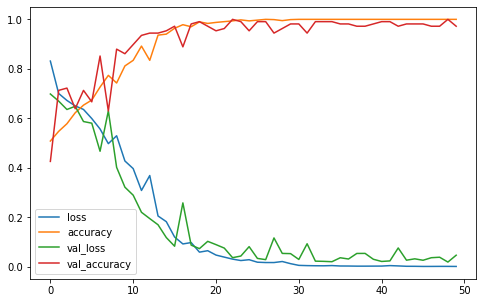

Results for fold 10
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.9270 - accuracy: 0.5031 - val_loss: 0.7304 - val_accuracy: 0.4444
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7535 - accuracy: 0.5185 - val_loss: 0.6637 - val_accuracy: 0.5556
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7210 - accuracy: 0.5432 - val_loss: 0.6582 - val_accuracy: 0.6111
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.7232 - accuracy: 0.5257 - val_loss: 0.6570 - val_accuracy: 0.7315
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7090 - accuracy: 0.5566 - val_loss: 0.6181 - val_accuracy: 0.6944
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6750 - accuracy: 0.5895 - val_loss: 0.6191 - val_accuracy: 0.6389
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6889 - accuracy: 0.5463 - val_loss: 0.5999 - val_acc

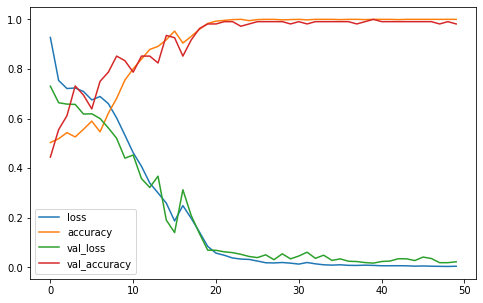

In [15]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9583333194255829
F1_Score  : 0.9577494497574298


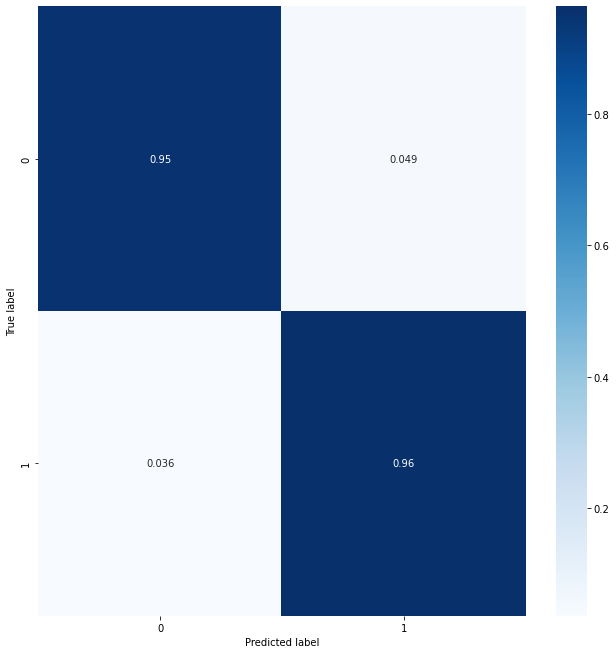

In [16]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()